# Market Basket Ananlysis
- 장바구니분석(Market Basket Analysis)은 거래내역(Transaction)을 통해 고객이 구매한 상품 간의 연관 관계 또는 규칙를 찾을 때 사용하는 분석기법이다.
   - (연관규칙의 표현) 항목 A와 품목 B를 구매한 고객은 품목 C를 구매한다: (품목 A) & (품목 B) => (품목 C)
- 교차판매, 상품진열, 부정탐지, 상품 카달로그 디자인 등에 주로 활용된다.

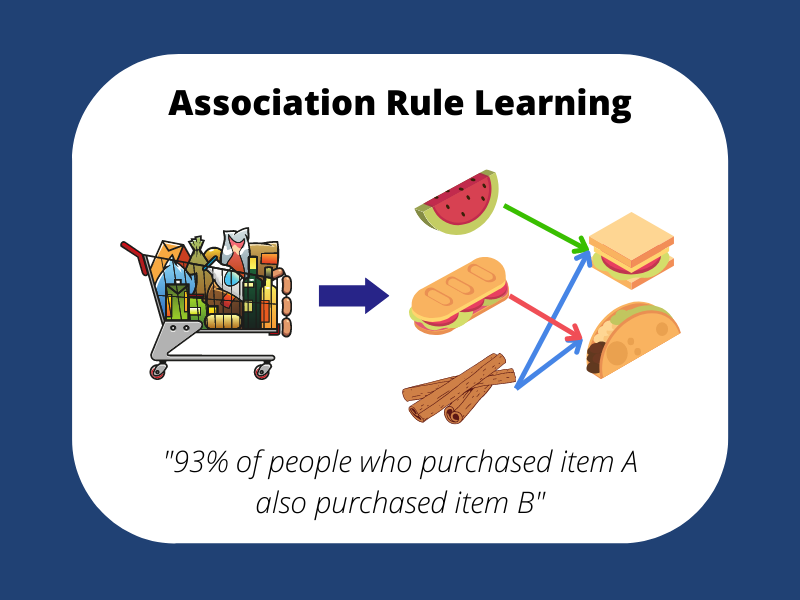

In [ ]:
import pandas as pd
from glob import glob
import os
import numpy as np
from tqdm import tqdm, tqdm_notebook
import plotly.offline as pyo
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from datetime import datetime
from datetime import date

In [ ]:
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook"

In [ ]:
pd.options.display.float_format = '{:.4f}'.format

In [ ]:
%matplotlib inline
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
import platform

path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)  

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
user = pd.read_pickle("../TBWA/user_fin2.pkl")
order = pd.read_pickle("../TBWA/order_fin.pkl")

## 거래상품 보기

In [ ]:
#order.카테고리3.unique() # 118개

In [ ]:
df = order.groupby(['고유번호', '카테고리3'], as_index = False).agg({'구매일자' : 'count'})
df.rename(columns = {'구매일자' : 'buy_ct'}, inplace = True)

In [ ]:
dummy = pd.get_dummies(df['카테고리3'])
dummy = df.join(dummy.add_prefix('카테고리_'))

In [ ]:
dummy = dummy.drop(labels = ['카테고리3'], axis = 1)
dummy = dummy.drop(labels = ['buy_ct'], axis = 1)

In [ ]:
dummy = dummy.groupby('고유번호', as_index=False).sum()

In [ ]:
transactions = dummy.copy()

In [ ]:
alist = []
blist = []
for i in transactions.columns[1:] :
    alist.append(i)
    blist.append(transactions[i].sum())

In [ ]:
pd.DataFrame({'column' : alist, 'value' : blist}).sort_values(by='value',  ascending=False).head(20)

,column,value
50,카테고리_LIFE STYLE,472370
110,카테고리_VULCANIZED,441190
86,카테고리_SNEAKER,294914
73,카테고리_RUNNING,290415
23,카테고리_COURT STYLE,242388
85,카테고리_SLIDE,136011
45,카테고리_JOGGER STYLE,117607
75,카테고리_SANDAL,100102
57,카테고리_MULE,99109
17,카테고리_CASUAL,68043


In [ ]:
## 빈발항목집합 추출 - Apriori

In [ ]:
# 대표적인 연관규칙탐사 알고리즘인 Apriori를 실행하기 위해서는 mlxtend 패키지를 설치해야 함
!pip install mlxtend

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.6 MB/s eta 0:00:00a 0:00:01


In [ ]:
from mlxtend.frequent_patterns import apriori, association_rules

In [ ]:
transactions = transactions.drop(labels = ['고유번호'], axis = 1)

In [ ]:
# 지지도(support)가 5% 이상인 빈발항목집합(itemsets)만 추출하고 지지도 기준 내림차순으로 출력
freq_items = apriori(transactions, min_support=0.07, use_colnames=True)
freq_items.sort_values(by='support', ascending=False)

/Users/dli2/opt/anaconda3/lib/python3.9/site-packages/mlxtend/frequent_patterns/fpcommon.py:111: DeprecationWarning:

DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type



,support,itemsets
2,0.3457,(카테고리_LIFE STYLE)
8,0.3229,(카테고리_VULCANIZED)
7,0.2158,(카테고리_SNEAKER)
4,0.2125,(카테고리_RUNNING)
0,0.1774,(카테고리_COURT STYLE)
12,0.1090,"(카테고리_VULCANIZED, 카테고리_LIFE STYLE)"
6,0.0995,(카테고리_SLIDE)
1,0.0861,(카테고리_JOGGER STYLE)
10,0.0856,"(카테고리_LIFE STYLE, 카테고리_RUNNING)"
5,0.0733,(카테고리_SANDAL)


- 특별히 옵션을 주지 않으면 기본 지지도(support)는 0.5로 설정된다. 이번에는 옵션을 넣어 지지도를 좀더 낮춰본다.
- 실제 데이터를 돌렸을땐 이처럼 낮은 지지도를 형성하는 경우가 많았다.심할때는 옵션에 support 를 0.001 을 주기도 한다고 한다.

## 연관규칙 도출

- min_threshold 의 기본값은 0.8 이다.
- 그런데 위에서 지지도가 낮은것을 억지로 보이게 했으니 신뢰도도 상대적으로 낮게 설정해야 목록이 좀 보인다.
- lift(향상도) 수치가 1보다 큰것들이 있는데, 1보다 클수록 우연히 일어나지 않았다는 표시다. 아무런 관계가 없다면 1로 표시된다.

In [ ]:
rules = association_rules(freq_items, metric="lift", min_threshold=1)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(카테고리_LIFE STYLE),(카테고리_COURT STYLE),0.3457,0.1774,0.0711,0.2057,1.1594,0.0098,1.0356
1,(카테고리_COURT STYLE),(카테고리_LIFE STYLE),0.1774,0.3457,0.0711,0.4008,1.1594,0.0098,1.0920
2,(카테고리_LIFE STYLE),(카테고리_RUNNING),0.3457,0.2125,0.0856,0.2478,1.1657,0.0122,1.0468
3,(카테고리_RUNNING),(카테고리_LIFE STYLE),0.2125,0.3457,0.0856,0.4030,1.1657,0.0122,1.0960


- support(지지도)

  - 전체 거래에서 특정 물품 A와 B가 동시에 거래되는 비중

  - 해당 규칙이 얼마나 의미있는지 보여줌.

 

  - 지지도 = P(A∩B)

    :A와 B가 동시에 일어난 횟수 / 전체 거래 횟수

- confiddence(신뢰도)

  - A를 포함하는 거래 중 A와 B가 동시에 거래되는 비중
  - 신뢰도 = P(A∩B) / P(A)

    :A와 B가 동시에 일어난 횟수 / A가 일어난 횟수

- lift(향상도)

  - A라는 상품에서 신뢰도가 동일한 상품 B와 C가 존재할 때, 어떤 상품을 더 추천해야 좋을지 판단.

  - A와 B가 동시에 거래된 비중을 A와 B가 서로 독립된 사건일 때 동시에 거래된 비중으로 나눈 값

  - 향상도 = P(A∩B) / P(A)*P(B) = P (B|A) / P (B)

    : A와 B가 동시에 일어난 횟수 / A, B가 독립된 사건일 때 A,B가 동시에 일어날 확률